In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PINN.utilities import collocation_points
from PINN.VanillaOptions import VanillaOptionPINN

In [47]:
K = 100
sigma = 0.3
r = 0.05
T = 1
S_inf = 2 * K

np.random.seed(128)
torch.manual_seed(128);

## European

In [48]:
TYPE = 'put'
STYLE = 'european'
SAMPLING = 'uniform'
SAVE = True
N_i = 100
N_b = 50
# N_i = 300
# N_b = 100

if SAMPLING == 'uniform':
    # initial condition (expiry)
    # put: V(0, S) = max(K - S, 0)
    # call: V(0, S) = max(S - K, 0)
    S_ib = torch.rand(N_i, 1)*S_inf
    tau_ib = torch.zeros(N_i, 1)
    V_ib = torch.max(K - S_ib, torch.zeros_like(S_ib)) if TYPE == 'put' else torch.max(S_ib - K, torch.zeros_like(S_ib))
    # boundary conditions
    # put: V(tau, 0) = K*exp(-r*tau), V(tau, S_inf) = 0
    # call: V(tau, 0) = 0, V(tau, S_inf) = S_inf - K*exp(-r*tau)
    S_ib = torch.cat([S_ib, torch.zeros(N_b, 1), torch.full((N_b, 1), S_inf)], dim=0)
    tau_ib = torch.cat([tau_ib, torch.rand(2*N_b, 1)*T], dim=0)
    if TYPE == 'put':
        V_ib = torch.cat([V_ib, K*torch.exp(-r*tau_ib[N_i:N_i+N_b]), torch.zeros((N_b, 1))], dim=0)
    else:
        V_ib = torch.cat([V_ib, torch.zeros((N_b, 1)), S_inf-K*torch.exp(-r*tau_ib[N_i:N_i+N_b])], dim=0)
elif SAMPLING == 'sobol':
    # initial condition
    # put: V(0, S) = max(K - S, 0)
    # call: V(0, S) = max(S - K, 0)
    sobol = torch.quasirandom.SobolEngine(dimension=1)
    S_ib = S_inf*sobol.draw(N_i).reshape(-1, 1)
    tau_ib = torch.zeros(N_i, 1)
    V_ib = torch.max(K - S_ib, torch.zeros_like(S_ib)) if TYPE == 'put' else torch.max(S_ib - K, torch.zeros_like(S_ib))
    # boundary conditions
    # put: V(tau, 0) = K*exp(-r*tau), V(tau, S_inf) = 0
    # call: V(tau, 0) = 0, V(tau, S_inf) = S_inf - K*exp(-r*tau)
    sobol = torch.quasirandom.SobolEngine(dimension=1)
    S_ib = torch.cat([S_ib, torch.zeros(N_b, 1), torch.full((N_b, 1), S_inf)], dim=0)
    tau_sobol = T*sobol.draw(N_b).reshape(-1, 1)
    tau_ib = torch.cat([tau_ib, tau_sobol, tau_sobol], dim=0)
    if TYPE == 'put':
        V_ib = torch.cat([V_ib, K*torch.exp(-r*tau_ib[N_i:N_i+N_b]), torch.zeros((N_b, 1))], dim=0)
    else:
        V_ib = torch.cat([V_ib, torch.zeros((N_b, 1)), S_inf-K*torch.exp(-r*tau_ib[N_i:N_i+N_b])], dim=0)

if STYLE == 'american':
    intrinsic = torch.where(torch.tensor(TYPE == 'put'),
                            torch.max(K - S_ib, torch.zeros_like(S_ib)),
                            torch.max(S_ib - K, torch.zeros_like(S_ib)))
    V_ib = torch.max(V_ib, intrinsic)

if SAVE:
    S_ib.requires_grad = True
    tau_ib.requires_grad = True
    V_ib.requires_grad = True
    torch.save({'S': S_ib, 'tau': tau_ib, 'V': V_ib}, f'./data/{STYLE}_{TYPE}_ib_{SAMPLING}.pt')

Number of ib points: 200


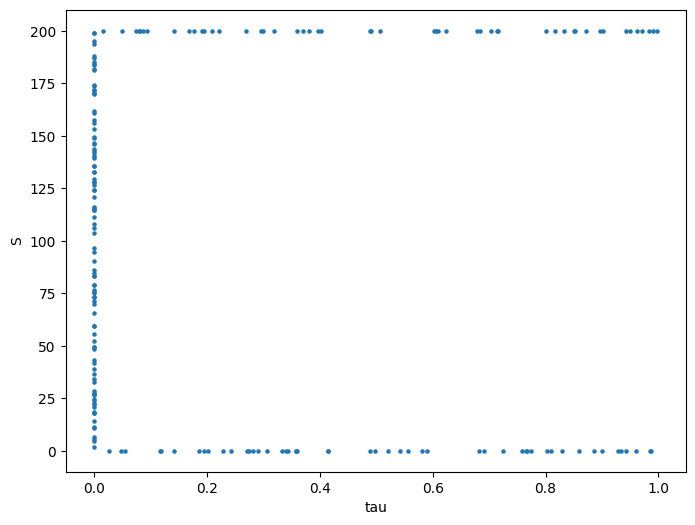

In [49]:
# load data
ib = torch.load(f'./data/{STYLE}_{TYPE}_ib_{SAMPLING}.pt')
S_ib = ib['S']
tau_ib = ib['tau']
V_ib = ib['V']
print('Number of ib points:', len(tau_ib))

# plot initial and boundary points
plt.figure(figsize=(8, 6))
plt.scatter(tau_ib.detach().numpy(), S_ib.detach().numpy(), s=5)
plt.xlabel('tau')
plt.ylabel('S')
plt.show()

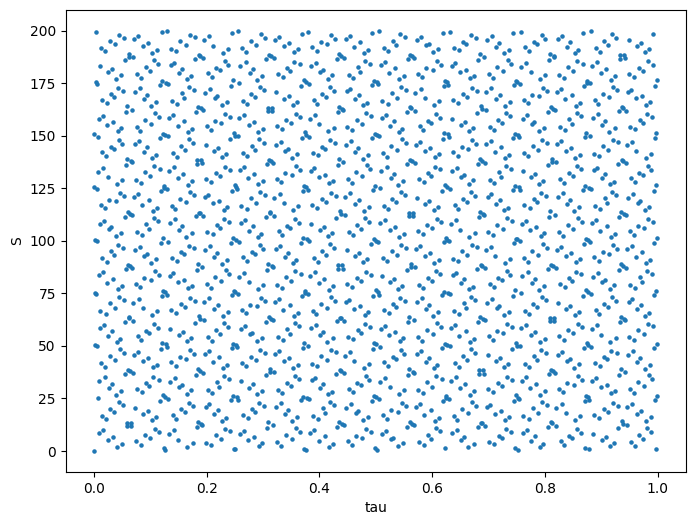

In [7]:
N_pde = 2000

nn = torch.nn.Sequential(
        torch.nn.Linear(2, 20),
        torch.nn.Tanh(),
        torch.nn.Linear(20, 20),
        torch.nn.Tanh(),
        torch.nn.Linear(20, 1)
)
model = VanillaOptionPINN(nn, K, T, sigma, r, S_inf,
                          type='put', style='european')
sobol = torch.quasirandom.SobolEngine(dimension=2)
tau_pde, S_pde = collocation_points(model, N_pde, sampling='sobol', sobol=sobol)

# plot
plt.figure(figsize=(8, 6))
plt.scatter(tau_pde.detach().numpy(), S_pde.detach().numpy(), s=5)
plt.xlabel('tau')
plt.ylabel('S')
plt.show()